# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
## IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs682/assignment1'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs682/assignment1


In [2]:

from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    # Don't forget to run get_datasets.sh, or this will throw an error
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs682.features import *

num_color_bins = 20 # Number of bins in the color histogram. Originally 10
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7, 1e-6]
regularization_strengths = [5e3, 5e4, 5e5, 5e6] # 5e7 is useless

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# train SVM model on X_val
for lr in learning_rates:
    for rs in regularization_strengths:

      print("learning rate:", lr, "reg strength", rs)

      svm_tune = LinearSVM()
      loss_hist = svm_tune.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                            num_iters=1500, verbose=True)

      # evaluate the performance on both the training and validation set
      y_train_pred_tune = svm_tune.predict(X_train_feats)
      train_tune_acc = np.mean(y_train == y_train_pred_tune)
      print('training accuracy: %f' % (train_tune_acc, ))

      y_val_pred_tune = svm_tune.predict(X_val_feats)
      val_tune_acc = np.mean(y_val == y_val_pred_tune)
      print('validation accuracy: %f' % (val_tune_acc, ))

      results[(lr, rs)] = (train_tune_acc, val_tune_acc)

      # if validation accuracy value is greater than the current stored one
      # (best_val), then store it and the current SVM object
      if best_val <= val_tune_acc:
          best_val = val_tune_acc
          best_svm = svm_tune
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate: 1e-09 reg strength 5000.0
iteration 0 / 1500: loss 16.833462
iteration 100 / 1500: loss 16.807901
iteration 200 / 1500: loss 16.808387
iteration 300 / 1500: loss 16.783683
iteration 400 / 1500: loss 16.762551
iteration 500 / 1500: loss 16.752882
iteration 600 / 1500: loss 16.744551
iteration 700 / 1500: loss 16.730787
iteration 800 / 1500: loss 16.691807
iteration 900 / 1500: loss 16.681862
iteration 1000 / 1500: loss 16.673063
iteration 1100 / 1500: loss 16.664793
iteration 1200 / 1500: loss 16.656545
iteration 1300 / 1500: loss 16.629101
iteration 1400 / 1500: loss 16.617553
training accuracy: 0.099551
validation accuracy: 0.095000
learning rate: 1e-09 reg strength 50000.0
iteration 0 / 1500: loss 89.142820
iteration 100 / 1500: loss 87.556323
iteration 200 / 1500: loss 86.020054
iteration 300 / 1500: loss 84.478415
iteration 400 / 1500: loss 82.982600
iteration 500 / 1500: loss 81.529937
iteration 600 / 1500: loss 80.068413
iteration 700 / 1500: loss 78.677933
iterati

/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/linear_svm.py:166: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/linear_svm.py:166: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/linear_svm.py:188: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W


iteration 300 / 1500: loss inf
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
lr 1.000000e-09 reg 5.000000e+03 train accuracy: 0.099551 val accuracy: 0.095000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.092714 val accuracy: 0.116000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.094980 val accuracy: 0.089000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.423959 val accuracy: 0.434000
lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.118939 val accuracy: 0.114000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.095816 val accuracy: 0.095000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.419408 val accuracy: 0.42300

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.433


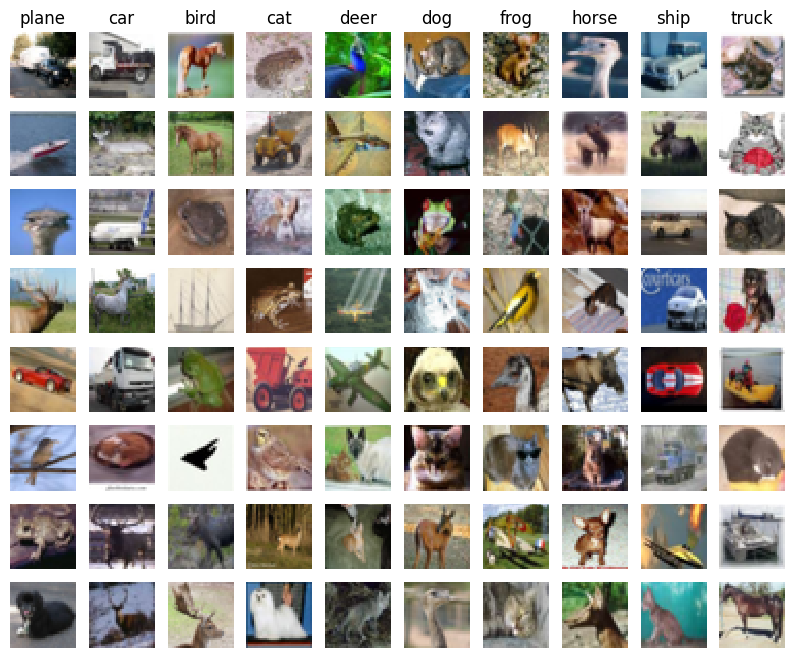

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

I can see why the algorithm misclassified many of these images. For example, in many of the plane misclassifications, there is a lot of blue in the background – the blue ocean and sky in the background of a ship, the blue sky in the background of a flying or perched bird. This misclassification makes sense. Similar deal with the dog category in which many of the misclassifications are images of cats and horses. This also makes sense because both animals have brownish/earthen fur, have four legs, and tend to be in similar backdrops. Backdrops could be grass, carpet, a meadow. All in all, these misclassification results make sense.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 165)
(49000, 164)


In [12]:
from cs682.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
# hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

learning_rates = [.5, .37]   # lr = .5 is flames
# regularization_strengths = [.002, .0025, .025]
regularization_strengths = [.0025]
# batch_sizes = [200, 400, 600]
batch_sizes = [500]
# hidden_sizes = [300, 500, 700]  # number of H neurons/nodes in the hidden layer
hidden_sizes = [500]

# best lr = 1e-3, rs = .0025


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
      for bs in batch_sizes:
        for hs in hidden_sizes:
          print("learning rate:", lr, "reg strength", rs)

          nn_tune = TwoLayerNet(input_dim, hs, num_classes)
          loss_hist = nn_tune.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr, learning_rate_decay=0.95,
                                    reg=rs, num_iters=1500, batch_size=bs,  verbose=True)

          # evaluate the performance on both the training and validation set
          y_train_pred_tune = nn_tune.predict(X_train_feats)
          train_tune_acc = np.mean(y_train == y_train_pred_tune)
          print('training accuracy: %f' % (train_tune_acc, ))

          y_val_pred_tune = nn_tune.predict(X_val_feats)
          val_tune_acc = np.mean(y_val == y_val_pred_tune)
          print('validation accuracy: %f' % (val_tune_acc, ))

          results[(lr, rs)] = (train_tune_acc, val_tune_acc)

          # if validation accuracy value is greater than the current stored one
          # (best_val), then store it and the current SVM object
          if best_val <= val_tune_acc:
              best_val = val_tune_acc
              best_net = nn_tune

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

learning rate: 0.5 reg strength 0.0025
iteration 0 / 1500: loss 2.302587
iteration 100 / 1500: loss 1.483180
iteration 200 / 1500: loss 1.352050
iteration 300 / 1500: loss 1.424100
iteration 400 / 1500: loss 1.303762
iteration 500 / 1500: loss 1.375678
iteration 600 / 1500: loss 1.397362
iteration 700 / 1500: loss 1.307526
iteration 800 / 1500: loss 1.266586
iteration 900 / 1500: loss 1.321588
iteration 1000 / 1500: loss 1.191115
iteration 1100 / 1500: loss 1.309704
iteration 1200 / 1500: loss 1.314654
iteration 1300 / 1500: loss 1.177821
iteration 1400 / 1500: loss 1.222533
training accuracy: 0.630449
validation accuracy: 0.599000
learning rate: 0.37 reg strength 0.0025
iteration 0 / 1500: loss 2.302587
iteration 100 / 1500: loss 1.713693
iteration 200 / 1500: loss 1.402854
iteration 300 / 1500: loss 1.445328
iteration 400 / 1500: loss 1.332332
iteration 500 / 1500: loss 1.466351
iteration 600 / 1500: loss 1.363625
iteration 700 / 1500: loss 1.270513
iteration 800 / 1500: loss 1.31590

In [13]:
best_val

0.599

In [14]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.563


In [22]:
# !bash collectSubmission.sh

  adding: readme.md (deflated 28%)
  adding: cs682/ (stored 0%)
  adding: cs682/data_utils.py (deflated 67%)
  adding: cs682/__init__.py (stored 0%)
  adding: cs682/features.py (deflated 60%)
  adding: cs682/vis_utils.py (deflated 61%)
  adding: cs682/classifiers/ (stored 0%)
  adding: cs682/classifiers/__init__.py (deflated 38%)
  adding: cs682/classifiers/k_nearest_neighbor.py (deflated 76%)
  adding: cs682/classifiers/linear_svm.py (deflated 66%)
  adding: cs682/classifiers/softmax.py (deflated 69%)
  adding: cs682/classifiers/linear_classifier.py (deflated 70%)
  adding: cs682/classifiers/neural_net.py (deflated 72%)
  adding: cs682/gradient_check.py (deflated 66%)
  adding: knn.ipynb (deflated 29%)
  adding: svm.ipynb (deflated 30%)
  adding: softmax.ipynb (deflated 41%)
  adding: two_layer_net.ipynb (deflated 25%)
  adding: features.ipynb (deflated 72%)
